In [1]:
from power_spectrum import *
%matplotlib inline

In [2]:
nsims_train = 10**5
nsims_test = 10**3

def spectral_index(params):
    def f(k):
        if k==0:
            return zeros(len(params))
        return k**(-4*params)
    return f

sims = lambda p: fast_gaussian(spectral_index(p[:,0]))

In [3]:
import time

start=time.time()

p_train = rand(nsims_train,1)
p_test = rand(nsims_test, 1)

x_train = sims(p_train)
x_test = sims(p_test)

print(f"{nsims_train+nsims_test} sims: {time.time()-start:.3f} seconds")

101000 sims: 12.376 seconds


In [63]:
from ipywidgets import interactive

def plot_field(x):
    m = amax(abs(x))
    imshow(x, vmin=-m, vmax=m, cmap="bwr")
    colorbar()

interactive(lambda spec_ind: plot_field(sims(np.array([[spec_ind]]))[0]), spec_ind=(0.,1.))

interactive(children=(FloatSlider(value=0.5, description='spec_ind', max=1.0), Output()), _dom_classes=('widge…

array([0.10837262])

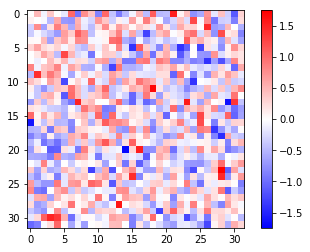

In [5]:
i = randint(nsims_train)
plot_field(x_train[i])
p_train[i]

In [7]:
class one_param_1(LFI):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=0.2,
                model_dir=None,
                config=None,
                n_samples = 2000):
        self.labels = label_columns
        self.n_samples = n_samples

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=dropout,training=training),256,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=dropout,training=training),64,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),16,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),4,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),1)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.tanh)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(n_samples)
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(y),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(y)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.00002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(feature_columns,label_columns,
                                             model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = one_param_1(["field"], ["power spectral index"], model_dir='/global/cscratch1/sd/avirukt/models/psi1')
model.train(training_fn_generator(x_train, p_train), max_steps=30*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/psi1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaaef239828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


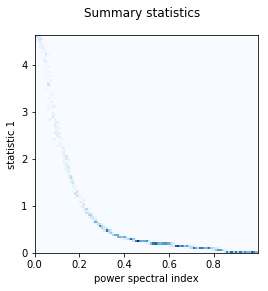

In [8]:
model.plot_summaries(x_test,p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


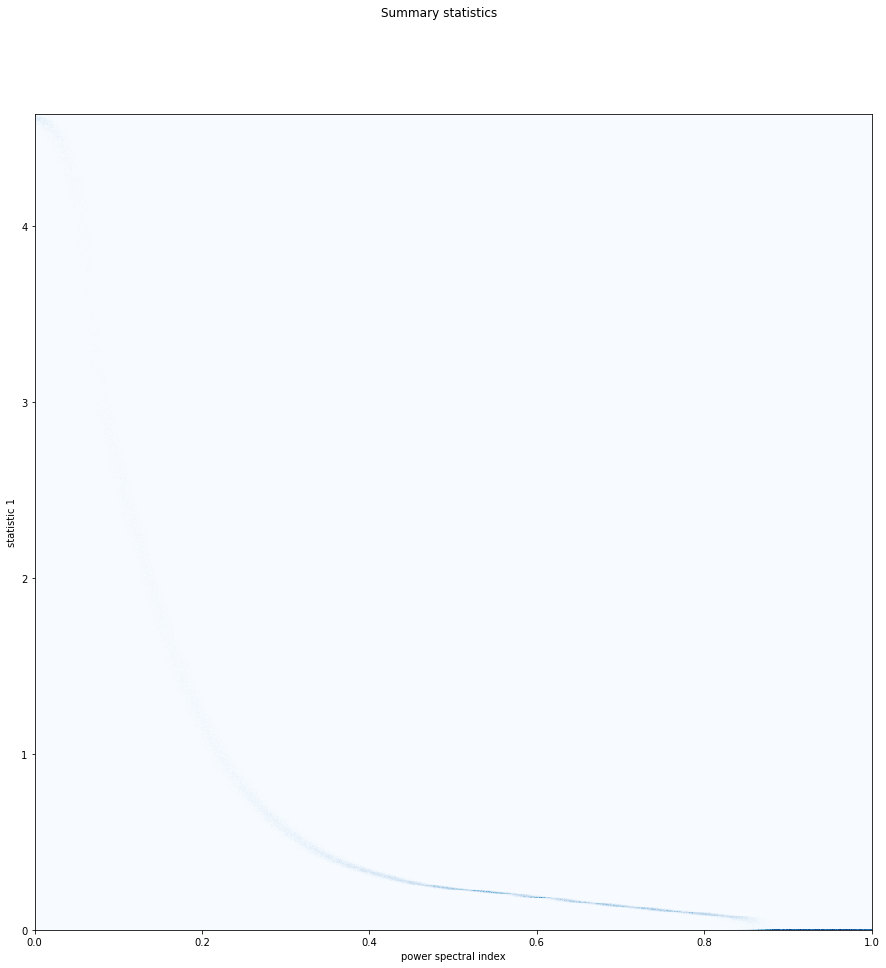

In [166]:
model.plot_summaries(x_train,p_train,1000,15)

In [88]:
posterior_samples = model.plot_posteriors(x_test, p_test, compare = lambda x: [lambda p: exp(-likelihood(array([x]),p,spectral_index)[0])])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in add
  


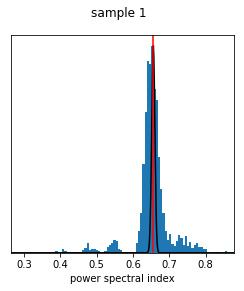

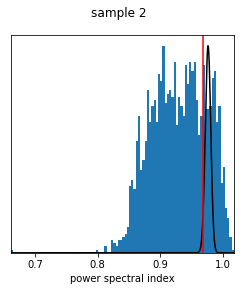

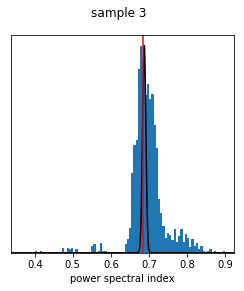

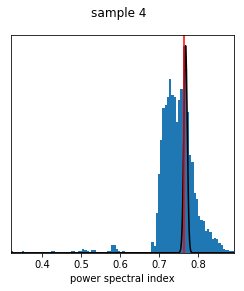

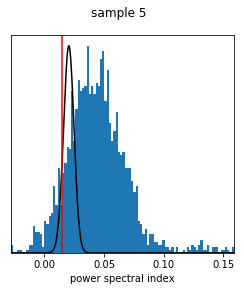

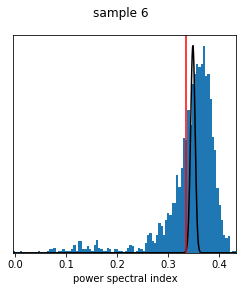

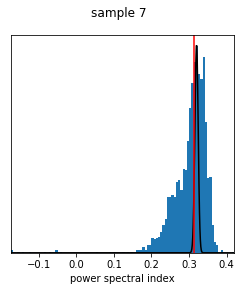

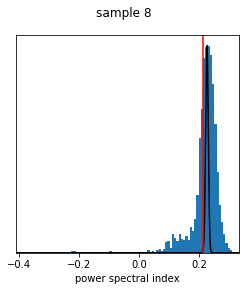

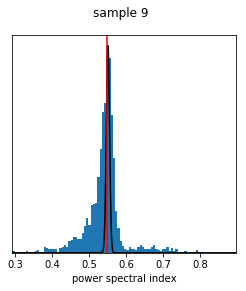

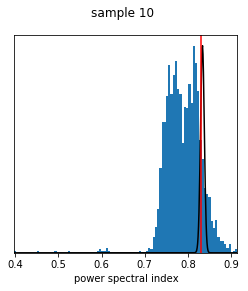

In [89]:
for j in range(10):
    next(posterior_samples)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


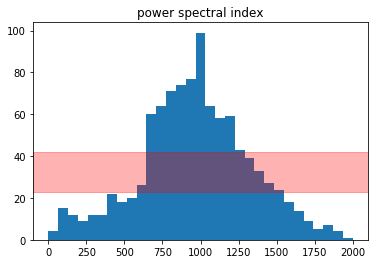

In [97]:
model.plot_ranks(x_test,p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


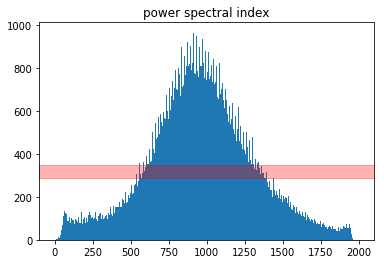

In [98]:
model.plot_ranks(x_train,p_train)

In [34]:
class regressor(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=0.2,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=dropout,training=training),256,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=dropout,training=training),64,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),16,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),4,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),1)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.00002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
        self.labels = label_columns
    
reg = regressor(["field"], ["power spectral index"], model_dir='/global/cscratch1/sd/avirukt/models/psir1')
reg.train(training_fn_generator(x_train, p_train), max_steps=30*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/psir1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaaefb735f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.


[0.82205669]


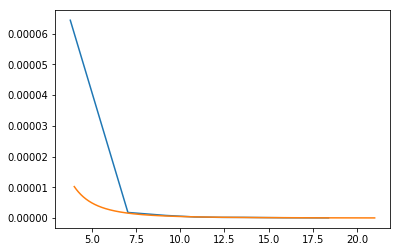

In [13]:
i = randint(nsims_train)
plot(*dynamic_ps(x_train[i],100)[:2])
k_mesh = linspace(4,21,1000)
f = spectral_index(p_train[i:i+1])
plot(k_mesh, [f(k)[0]/32**2 for k in k_mesh])
print(p_train[i])

In [14]:
x_train.ndim

3

In [15]:
p=40
d=2

In [16]:
crand = randn(d,10000)*(p/d)**.5
cr2s = sum(crand**2,axis=0)
crs = sqrt(cr2s)
mean(cr2s),mean(crs)**2

(40.38602091331981, 31.65924355093579)

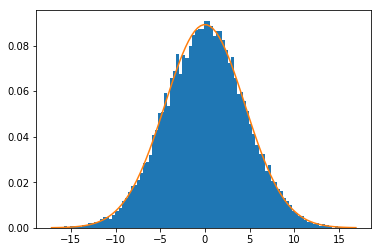

In [17]:
edges=hist(crand.flatten(),100,density=True)[1]
plot(edges, (2*pi*p/d)**-.5*np.exp(-edges**2*d/2/p))

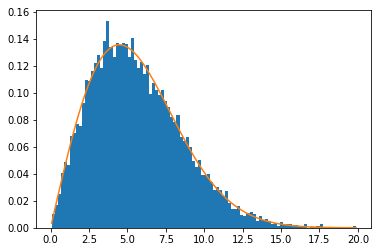

In [18]:
from scipy.special import gamma

edges = hist(crs, 100, density=True)[1]
plot(edges, d*np.exp(-edges**2*d/2/p)/(2*p/d)**(d/2)/gamma(d/2+1)*edges**(d-1))

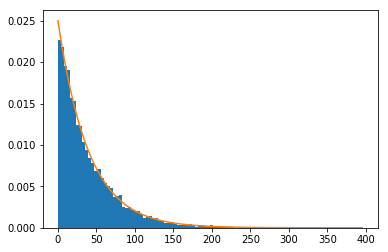

In [19]:
edges = hist(cr2s, 100, density=True)[1]
plot(edges, d/2*np.exp(-edges*d/2/p)/(2*p/d)**(d/2)/gamma(d/2+1)*edges**(d/2-1))
#plot(edges, np.exp(-edges/p)/p) #d=2 is so simple - simpler than d=1!

In [9]:
def likelihood(x,p,ps_fn,norm=True):
    size = x.shape[-1]
    d = x.ndim-1
    nx = x.shape[0]
    np = len(p)
    shape = [size]*(d-1)+[size//2+1]
    ex = zeros([np]+shape)
    build_ps(ex,ps_fn(p),size,d)
    ex = ex.reshape([1]+[np]+shape)
    x = abs(fft.rfftn(x,axes=tuple(range(1,d+1)))/size**(d/2))**2
    x = x.reshape([nx]+[1]+shape)
    nll = x/ex+log(ex)
    nll[tuple([slice(None)]*2+[0]*d)]=0
    nll = sum(nll,axis=tuple(range(2,d+2)))
    if norm:
        nll -= amin(nll, axis=1).reshape((nx,1))
    return nll

In [18]:
from scipy.optimize import minimize_scalar

def ml_estimate(x,ps_fn,initial,bounds=None):
    ml = minimize_scalar(lambda p: likelihood(array([x]),array([p]),ps_fn,norm=False)[0,0])#,method="golden",bounds=bounds)
    assert ml.success, ml.message
    return ml.x

In [17]:
import warnings
warnings.filterwarnings(action='once')

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


(array([0.04005732]), 0.04567228083730885)

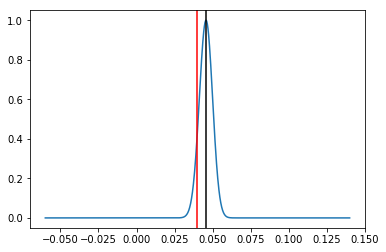

In [31]:
i = randint(nsims_train)
p = linspace(p_train[i]-.1,p_train[i]+.1,1000)
l = likelihood(x_train[i:i+1],p,spectral_index)[0]
plot(p,exp(-l))
axvline(p_train[i],c="r")
ml = ml_estimate(x_train[i],spectral_index,p_train[i])
axvline(ml,c="k")
p_train[i],ml

In [19]:
start = time.time()

bayesian_estimates = [ml_estimate(x_test[i],spectral_index,p_test[i]) for i in range(nsims_test)]

time.time()-start

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


113.92411208152771

Text(0, 0.5, 'max likelihood estimate')

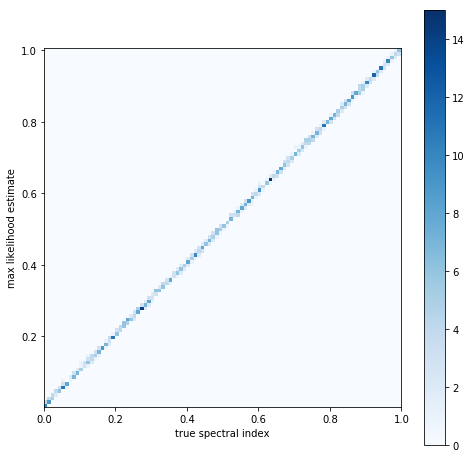

In [78]:
figure(figsize=(8,8))
hist2d(p_test.flatten(),bayesian_estimates,100,cmap="Blues")
colorbar()
gca().set_aspect("equal")
xlabel("true spectral index")
ylabel("max likelihood estimate")

Text(0.5, 1.0, 'max likelihood error')

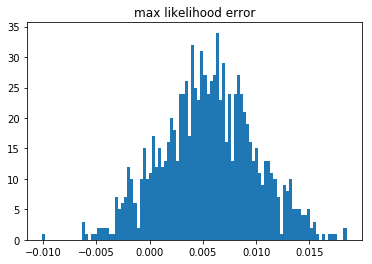

In [79]:
hist(array(bayesian_estimates)-p_test.flatten(),100)
title("max likelihood error")

In [34]:
lfi_estimates = [mean(p["samples"]) for p in model.predict(testing_fn_generator(x_test,p_test))]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'LFI mean posterior estimate')

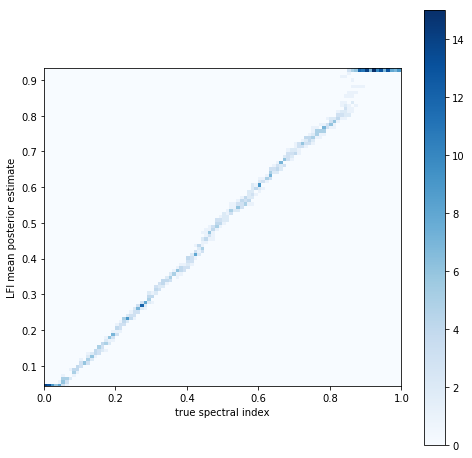

In [12]:
figure(figsize=(8,8))
hist2d(p_test.flatten(),lfi_estimates,100,cmap="Blues")
colorbar()
gca().set_aspect("equal")
xlabel("true spectral index")
ylabel("LFI mean posterior estimate")

Text(0.5, 1.0, 'LFI mean posterior error')

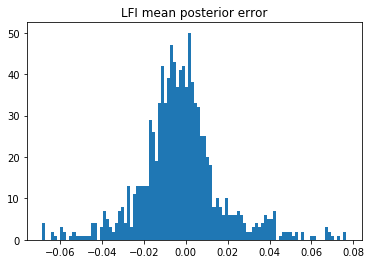

In [13]:
hist(array(lfi_estimates)-p_test.flatten(),100)
title("LFI mean posterior error")

In [35]:
reg_estimates = list(reg.predict(testing_fn_generator(x_test,p_test)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psir1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'regression estimate')

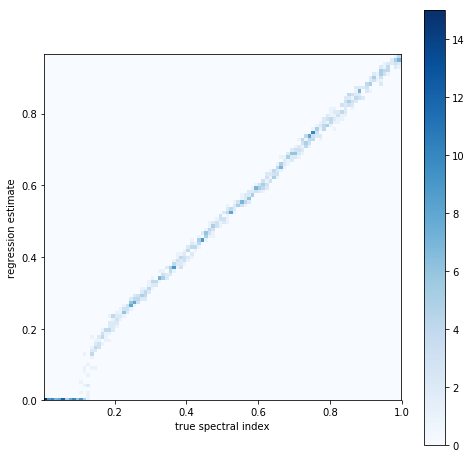

In [47]:
figure(figsize=(8,8))
hist2d(p_test.flatten(),reg_estimates,100,cmap="Blues")
colorbar()
gca().set_aspect("equal")
xlabel("true spectral index")
ylabel("regression estimate")

Text(0.5, 1.0, 'regression error')

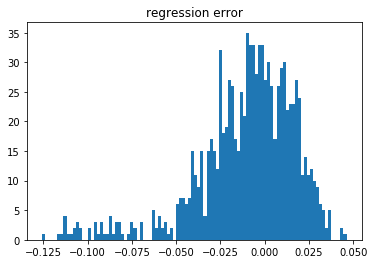

In [48]:
hist(array(reg_estimates).flatten()-p_test.flatten(),100)
title("regression error")

In [14]:
start=time.time()

training_stats  = np.array([p["stat"] for p in model.predict(testing_fn_generator(x_train,p_train))]).flatten()

time.time()-start

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
def easy_calibration(stat, num=10, step=0.1):
    tol = 1e-5
    indices = abs(training_stats-stat)<=tol
    while sum(indices) < num:
        tol *= 1+step
        indices = abs(training_stats-stat)<=tol
    #print(stat,tol,sum(indices),sum(p_train[indices])/sum(indices))
    #hist(p_train[indices],20)
    #axvline(sum(p_train[indices])/sum(indices),color="k")
    return sum(p_train[indices])/sum(indices)

In [16]:
easy_calibration(3.4,20)

3.4 0.004457915684525927 20 0.07089031967809205


0.07089031967809205

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


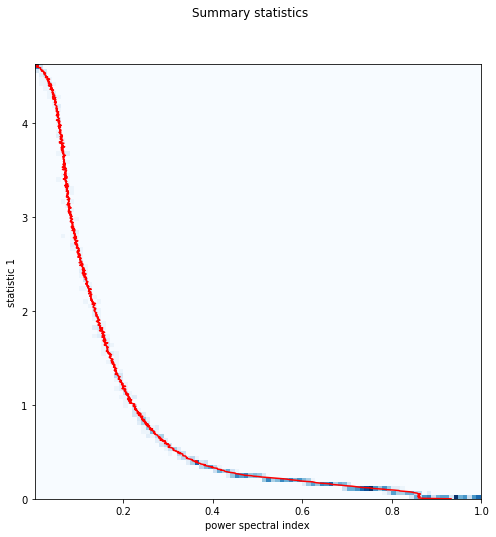

In [39]:
model.plot_summaries(x_test,p_test,figsize=8)
statmesh = linspace(amin(training_stats),amax(training_stats),1000)
plot([easy_calibration(p,10) for p in statmesh],statmesh,c="r")

In [23]:
start = time.time()

calibrated_estimates = [easy_calibration(p["stat"][0]) for p in model.predict(testing_fn_generator(x_test,p_test))]

time.time()-start

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


17.93920373916626

Text(0, 0.5, 'LFI calibrated summary')

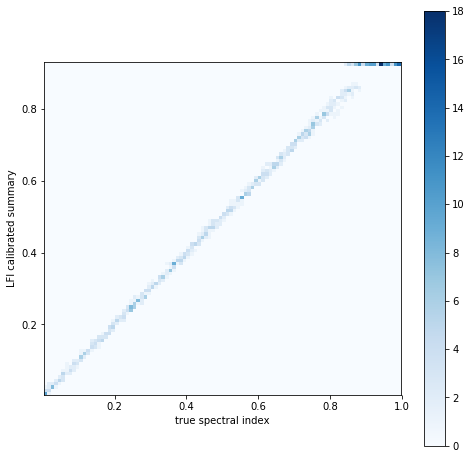

In [59]:
figure(figsize=(8,8))
hist2d(p_test.flatten(),calibrated_estimates,100,cmap="Blues")
colorbar()
gca().set_aspect("equal")
xlabel("true spectral index")
ylabel("LFI calibrated summary")

Text(0.5, 1.0, 'LFI calibrated summary error')

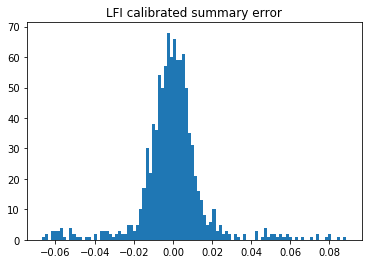

In [58]:
hist(array(calibrated_estimates).flatten()-p_test.flatten(),100)
title("LFI calibrated summary error")

max likelihood:
0.0057 ± 0.0045
loss = 0.0072

LFI mean posterior:
-0.0030 ± 0.0201
loss = 0.0204

LFI calibrated summary:
-0.0002 ± 0.0173
loss = 0.0173

regression:
-0.0102 ± 0.0279
loss = 0.0297



(0, 205.8)

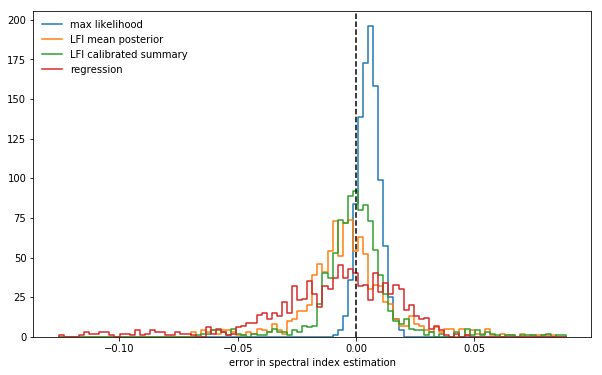

In [57]:
labels = ["max likelihood", "LFI mean posterior", "LFI calibrated summary", "regression"]
errors = array([bayesian_estimates, lfi_estimates, calibrated_estimates, reg_estimates])
errors -= p_test.T
nbins = 100
edges = linspace(amin(errors),amax(errors),nbins+1)

figure(figsize=(10,6))
for l,e in zip(labels, errors):
    plot(*corners(e,edges),label=l)
    print(l+":")
    print(f"{mean(e):.4f} \u00b1 {std(e):.4f}")
    print(f"loss = {mean(e**2)**.5:.4f}\n")
legend(frameon=False, loc="upper left")
axvline(0,c="k",ls="--")
xlabel("error in spectral index estimation")
ylim(0,gca().get_ylim()[1])

(0, 104.52960446268962)

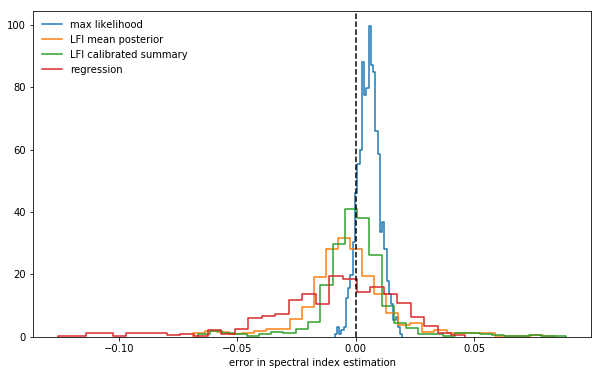

In [46]:
figure(figsize=(10,6))
for l,e in zip(labels, errors):
    plot(*corners(e,30,False,density=True),label=l)
legend(frameon=False, loc="upper left")
axvline(0,c="k",ls="--")
xlabel("error in spectral index estimation")
ylim(0,gca().get_ylim()[1])

In [4]:
lfi_model = LFI(["field"], ["power spectral index"], model_dir='/global/cscratch1/sd/avirukt/models/psi4')
lfi_model.train(training_fn_generator(x_train, p_train), max_steps=50*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/psi4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaaef0e8748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


KeyboardInterrupt: 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


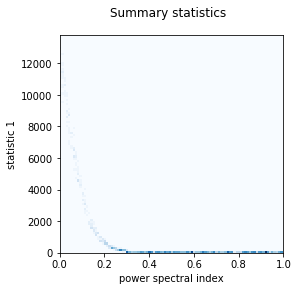

In [5]:
lfi_model.plot_summaries(x_test,p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi3/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


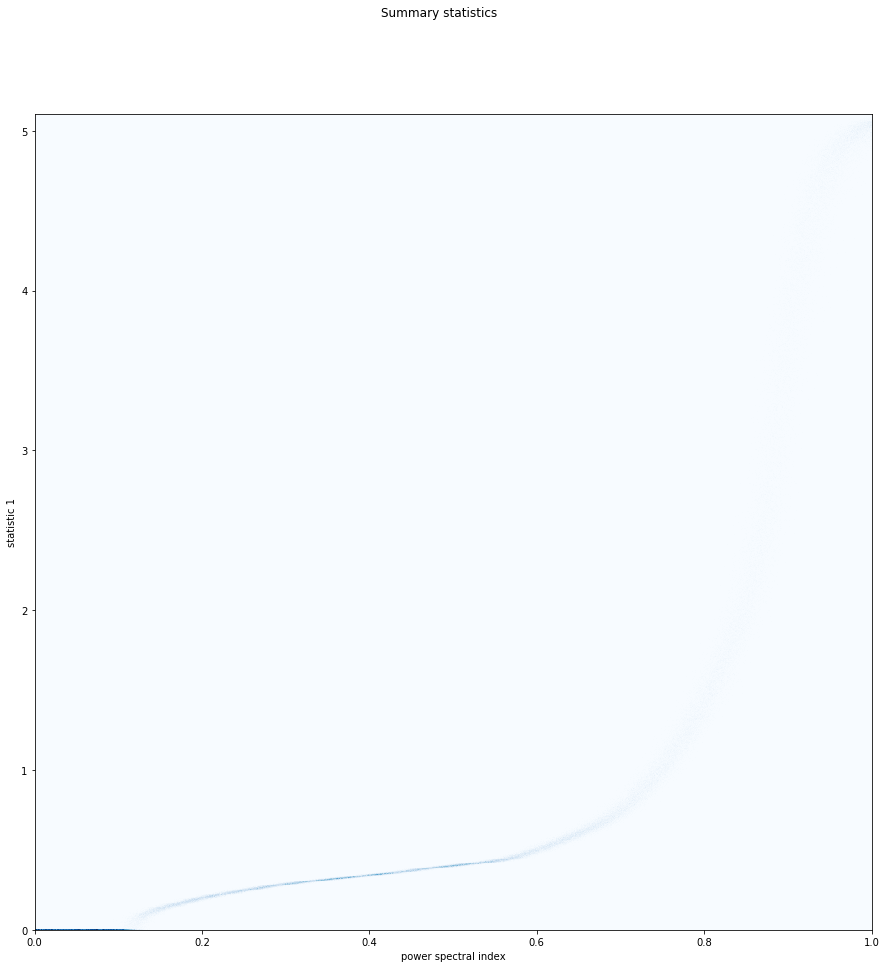

In [16]:
lfi_model.plot_summaries(x_train,p_train,100,8)

In [11]:
posterior_samples = lfi_model.plot_posteriors(x_test, p_test, compare = lambda x: [lambda p: exp(-likelihood(array([x]),p,spectral_index)[0])])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered i

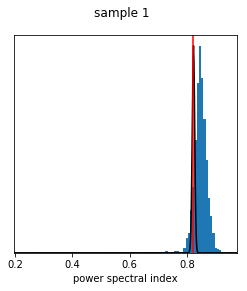

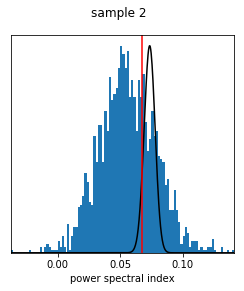

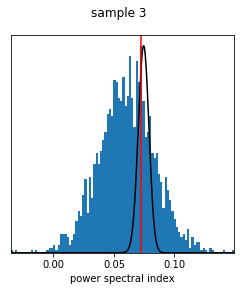

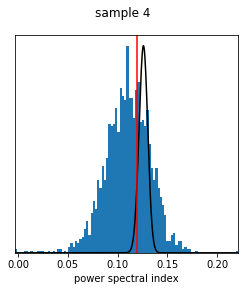

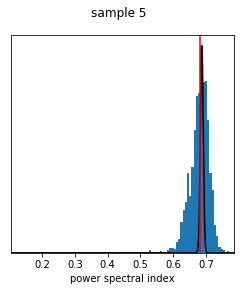

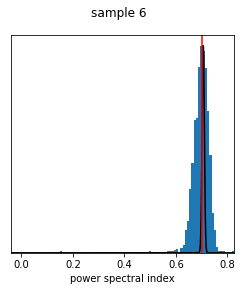

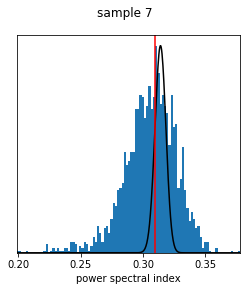

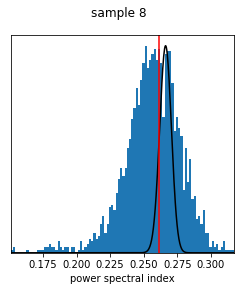

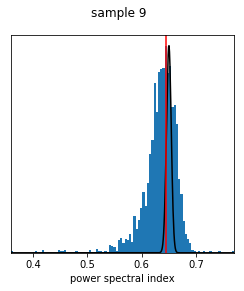

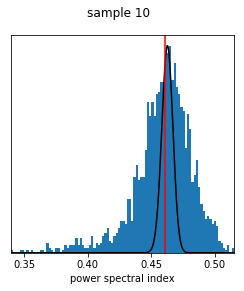

In [12]:
for j in range(10):
    next(posterior_samples)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


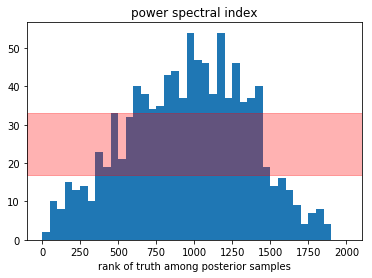

In [13]:
lfi_model.plot_ranks(x_test,p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi3/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


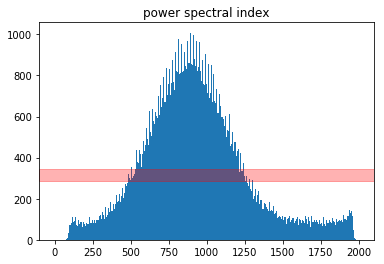

In [15]:
lfi_model.plot_ranks(x_train,p_train)

In [14]:
lfi_estimates = [mean(p["samples"]) for p in lfi_model.predict(testing_fn_generator(x_test,p_test))]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'LFI mean posterior estimate')

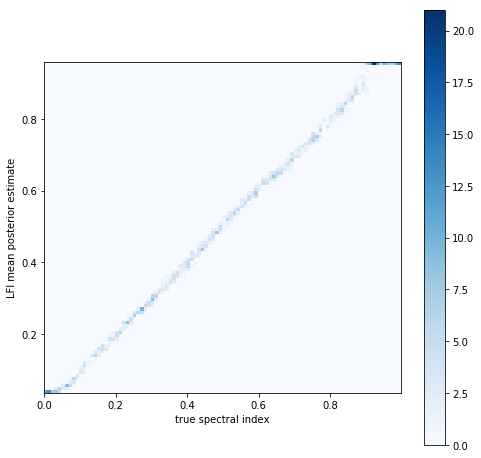

In [15]:
figure(figsize=(8,8))
hist2d(p_test.flatten(),lfi_estimates,100,cmap="Blues")
colorbar()
gca().set_aspect("equal")
xlabel("true spectral index")
ylabel("LFI mean posterior estimate")

Text(0.5, 1.0, 'LFI mean posterior error')

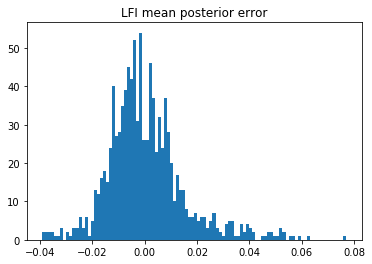

In [16]:
hist(array(lfi_estimates)-p_test.flatten(),100)
title("LFI mean posterior error")

In [17]:
start=time.time()

training_stats  = np.array([p["stat"] for p in lfi_model.predict(testing_fn_generator(x_train,p_train))]).flatten()

time.time()-start

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


23.185117483139038

In [18]:
def easy_calibration(stat, num=10, step=0.1):
    tol = 1e-5
    indices = abs(training_stats-stat)<=tol
    while sum(indices) < num:
        tol *= 1+step
        indices = abs(training_stats-stat)<=tol
    #print(stat,tol,sum(indices),sum(p_train[indices])/sum(indices))
    #hist(p_train[indices],20)
    #axvline(sum(p_train[indices])/sum(indices),color="k")
    return sum(p_train[indices])/sum(indices)

In [19]:
easy_calibration(3.4,20)

0.5268065901085209

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


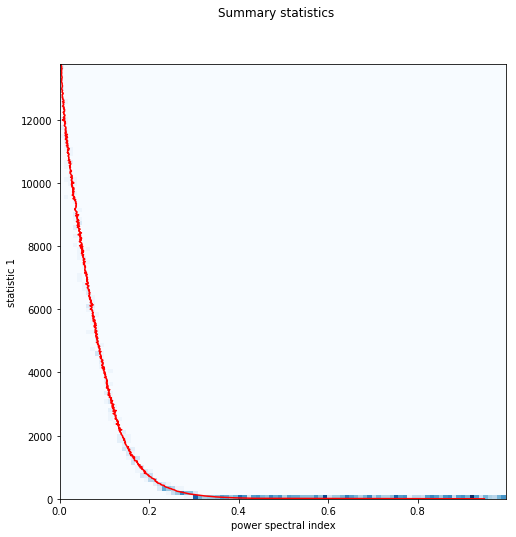

In [20]:
lfi_model.plot_summaries(x_test,p_test,figsize=8)
statmesh = linspace(amin(training_stats),amax(training_stats),1000)
plot([easy_calibration(p,20) for p in statmesh],statmesh,c="r")

In [21]:
start = time.time()

calibrated_estimates = [easy_calibration(p["stat"][0]) for p in lfi_model.predict(testing_fn_generator(x_test,p_test))]

time.time()-start

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/psi4/model.ckpt-30251
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


16.4771249294281

Text(0, 0.5, 'LFI calibrated summary')

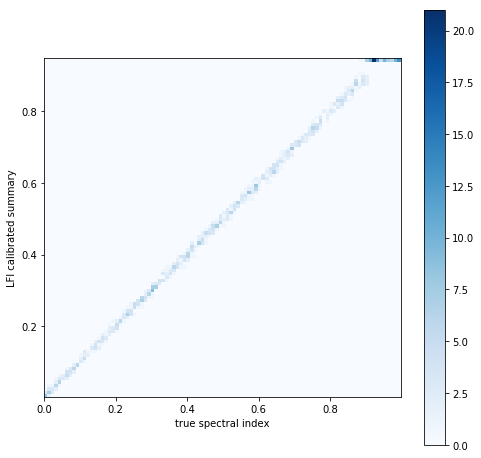

In [22]:
figure(figsize=(8,8))
hist2d(p_test.flatten(),calibrated_estimates,100,cmap="Blues")
colorbar()
gca().set_aspect("equal")
xlabel("true spectral index")
ylabel("LFI calibrated summary")

Text(0.5, 1.0, 'LFI calibrated summary error')

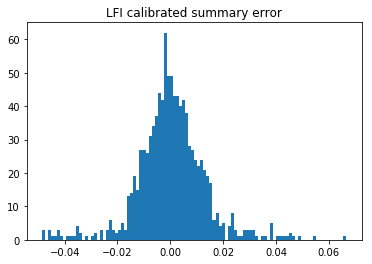

In [23]:
hist(array(calibrated_estimates).flatten()-p_test.flatten(),100)
title("LFI calibrated summary error")

max likelihood:
0.0055 ± 0.0044
RMS loss = 0.0071

LFI mean posterior:
0.0037 ± 0.0200
RMS loss = 0.0204

LFI calibrated summary:
-0.0004 ± 0.0149
RMS loss = 0.0149

regression:
-0.0117 ± 0.0289
RMS loss = 0.0312



(0, 183.75)

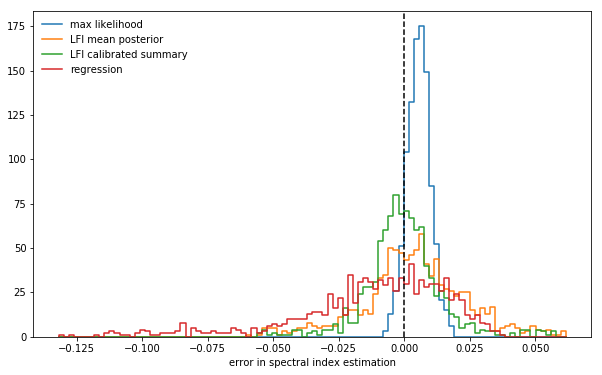

In [39]:
labels = ["max likelihood", "LFI mean posterior", "LFI calibrated summary", "regression"]
errors = array([bayesian_estimates, lfi_estimates, calibrated_estimates, reg_estimates])
errors -= p_test.T
nbins = 100
edges = linspace(amin(errors),amax(errors),nbins+1)

figure(figsize=(10,6))
for l,e in zip(labels, errors):
    plot(*corners(e,edges),label=l)
    print(l+":")
    print(f"{mean(e):.4f} \u00b1 {std(e):.4f}")
    print(f"RMS loss = {mean(e**2)**.5:.4f}\n")
legend(frameon=False, loc="upper left")
axvline(0,c="k",ls="--")
xlabel("error in spectral index estimation")
ylim(0,gca().get_ylim()[1])